<a href="https://colab.research.google.com/github/Nov05/Lambda-School-Data-Science/blob/master/LSDS_Intro_Assignment_8_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School, Intro to Data Science, Day 8 — Classification!

## Assignment

Run this cell to load the Titanic data:

In [0]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mean
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings('ignore')

In [66]:
# visulize decision tree
!pip install graphviz
!apt-get install graphviz
import graphviz
from sklearn.tree import export_graphviz

!pip install dtreeviz
!apt install graphviz
!apt install xdg-utils
from dtreeviz.trees import *

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
  Stored in directory: /root/.cache/pip/wheels/4c/3f/87/b2c828617d1bd181145fbaf41129e4c82fa8d9a98082701e00
Successfully built dtreeviz
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xdg-utils is already the newest version (1.1.2-1ubuntu2.3).
xdg-utils set to ma

In [0]:
from sklearn.metrics import confusion_matrix

def pred_matrix(y_true, y_pred):
    data = confusion_matrix(y_true, y_pred)
    index = ['Actual 0', 'Actual 1']
    columns = ['Predicted 0', 'Predicted 1']
    return pd.DataFrame(data, index, columns)

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(sns.load_dataset('titanic').drop(columns=['alive']), random_state=0)
target = 'survived'

## Data Exploration

In [26]:
train.shape

(668, 14)

In [27]:
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
105,0,3,male,28.0,0,0,7.8958,S,Third,man,True,NaN,Southampton,True
68,1,3,female,17.0,4,2,7.9250,S,Third,woman,False,NaN,Southampton,False
253,0,3,male,30.0,1,0,16.1000,S,Third,man,True,NaN,Southampton,False
320,0,3,male,22.0,0,0,7.2500,S,Third,man,True,NaN,Southampton,True
706,1,2,female,45.0,0,0,13.5000,S,Second,woman,False,NaN,Southampton,True


In [28]:
print('Column Name          Data Type')
for col in train.columns:
  print('{:20} {}'.format(col, train[col].dtype))

Column Name          Data Type
survived             int64
pclass               int64
sex                  object
age                  float64
sibsp                int64
parch                int64
fare                 float64
embarked             object
class                category
who                  object
adult_male           bool
deck                 category
embark_town          object
alone                bool


In [29]:
train.describe()

,survived,pclass,age,sibsp,parch,fare
count,668.000000,668.000000,535.000000,668.000000,668.000000,668.000000
mean,0.386228,2.305389,29.900000,0.534431,0.392216,32.373621
std,0.487249,0.837377,14.487993,1.161739,0.822509,50.632021
min,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,29.000000,0.000000,0.000000,14.500000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [30]:
train.describe(include=['object', 'category'])

,sex,embarked,class,who,deck,embark_town
count,668,666,668,668,156,666
unique,2,3,3,3,7,3
top,male,S,Third,man,C,Southampton
freq,437,490,367,407,43,490


In [31]:
train.embark_town.unique()

array(['Southampton', 'Cherbourg', 'Queenstown', nan], dtype=object)

## Fill NAs

In [32]:
# find out train data columns that contain NAs
train.isna().sum()

survived         0
pclass           0
sex              0
age            133
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           512
embark_town      2
alone            0
dtype: int64

In [33]:
# check test data NAs
test.isna().sum()

survived         0
pclass           0
sex              0
age             44
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
deck           176
embark_town      0
alone            0
dtype: int64

In [34]:
# drop column 'deck' due to too many NAs, fill column 'age' NAs with train data mean
age_mean = mean(train.age.dropna())
print(age_mean)

29.9


In [35]:
# test data column 'age' mean
mean(test.age.dropna())

29.098715083798883

In [36]:
# verify train data NAs are filled
train.age = train.age.fillna(age_mean)
train.age.isna().sum()

0

In [37]:
# verify test data NAs are filled
test.age = test.age.fillna(age_mean)
test.age.isna().sum()

0

## Encoding

In [38]:
# encode train data column 'sex'
le = LabelEncoder()
train[['sex']] = train[['sex']].apply(le.fit_transform)
train.sex.head()

105    1
68     0
253    1
320    1
706    0
Name: sex, dtype: int64

In [39]:
# encode test data column 'sex'
test[['sex']] = test[['sex']].apply(le.fit_transform)
test.sex.head()

495    1
648    1
278    1
31     0
255    0
Name: sex, dtype: int64

## Predicting

Then, train a [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba), [Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), or [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model. Use any features and parameters you want. 

Try to get better than 78.0% accuracy on the test set! (This is not required, but encouraged.)

Do refer to the lecture notebook — but try not to copy-paste.

> You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons. —*[Learn Python the Hard Way](https://learnpythonthehardway.org/book/intro.html)*

After this, you may want to try [Kaggle's Titanic challenge](https://www.kaggle.com/c/titanic)!

### Logistic Regression

In [0]:
features_all = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'alone']
target = 'survived'

In [101]:
# try Logistic Regression model with different feature combinations
model = LogisticRegression()
for i in range(2, 8):
  for comb in combinations(features_all, i):
    features = list(comb)
    model.fit(train[features], train[target])
    print('Features:', features)

    # Train accuracy
    y_true = train[target]
    y_pred = model.predict(train[features])
    print('Train accuracy:', accuracy_score(y_true, y_pred))

    # Test accuracy
    y_true = test[target]
    y_pred = model.predict(test[features])
    print('Test accuracy:', accuracy_score(y_true, y_pred))
    
    print('Recall score:', recall_score(y_true, y_pred))
    print('Coeffecient:', model.coef_[0])
    print('Intercept:', model.intercept_[0])
    print();

Features: ['pclass', 'sex']
Train accuracy: 0.7889221556886228
Test accuracy: 0.7802690582959642
Recall score: 0.7023809523809523
Coeffecient: [-0.76248867 -2.41428141]
Intercept: 2.726162717965825

Features: ['pclass', 'age']
Train accuracy: 0.6946107784431138
Test accuracy: 0.726457399103139
Recall score: 0.44047619047619047
Coeffecient: [-0.92523859 -0.03047743]
Intercept: 2.5166066161961713

Features: ['pclass', 'sibsp']
Train accuracy: 0.6691616766467066
Test accuracy: 0.7085201793721974
Recall score: 0.42857142857142855
Coeffecient: [-0.77435496 -0.03925429]
Intercept: 1.2973454899579637

Features: ['pclass', 'parch']
Train accuracy: 0.6796407185628742
Test accuracy: 0.7130044843049327
Recall score: 0.4523809523809524
Coeffecient: [-0.79169285  0.23613269]
Intercept: 1.2201218411226078

Features: ['pclass', 'fare']
Train accuracy: 0.6691616766467066
Test accuracy: 0.7085201793721974
Recall score: 0.42857142857142855
Coeffecient: [-0.6590593   0.00430866]
Intercept: 0.881044481259

### Decision Tree

In [100]:
# decision tree
model = DecisionTreeClassifier(random_state=555)

for i in range(2, 8):
  for comb in combinations(features_all, i):
    features = list(comb)
    model.fit(train[features], train[target])
    print('Features:', features)

    # Train accuracy
    y_true = train[target]
    y_pred = model.predict(train[features])
    print('Train accuracy:', accuracy_score(y_true, y_pred))

    # Test accuracy
    y_true = test[target]
    y_pred = model.predict(test[features])
    print('Test accuracy:', accuracy_score(y_true, y_pred))
    
    print('Recall score:', recall_score(y_true, y_pred))
    print('Feature importance:', model.feature_importances_)
    print();

Features: ['pclass', 'sex']
Train accuracy: 0.7889221556886228
Test accuracy: 0.7802690582959642
Recall score: 0.7023809523809523
Feature importance: [0.21457646 0.78542354]

Features: ['pclass', 'age']
Train accuracy: 0.7739520958083832
Test accuracy: 0.695067264573991
Recall score: 0.4166666666666667
Feature importance: [0.32148444 0.67851556]

Features: ['pclass', 'sibsp']
Train accuracy: 0.6856287425149701
Test accuracy: 0.7040358744394619
Recall score: 0.5238095238095238
Feature importance: [0.79197001 0.20802999]

Features: ['pclass', 'parch']
Train accuracy: 0.7065868263473054
Test accuracy: 0.726457399103139
Recall score: 0.5238095238095238
Feature importance: [0.79422923 0.20577077]

Features: ['pclass', 'fare']
Train accuracy: 0.8158682634730539
Test accuracy: 0.7040358744394619
Recall score: 0.5357142857142857
Feature importance: [0.22295946 0.77704054]

Features: ['pclass', 'alone']
Train accuracy: 0.7005988023952096
Test accuracy: 0.7130044843049327
Recall score: 0.5595238

### Decision Tree Visualization

In [96]:
features = ['sex', 'fare']
model = DecisionTreeClassifier(max_depth=3, random_state=555)
model.fit(train[features], train[target])
print('Features:', features)

# Train accuracy
y_true = train[target]
y_pred = model.predict(train[features])
print('Train accuracy:', accuracy_score(y_true, y_pred))

# Test accuracy
y_true = test[target]
y_pred = model.predict(test[features])
print('Test accuracy:', accuracy_score(y_true, y_pred))

print('Recall score:', recall_score(y_true, y_pred))
print('Feature importance:', model.feature_importances_)

Features: ['sex', 'fare']
Train accuracy: 0.7994011976047904
Test accuracy: 0.7757847533632287
Recall score: 0.7142857142857143
Feature importance: [0.83169961 0.16830039]


In [97]:
pred_matrix(y_true, y_pred)

,Predicted 0,Predicted 1
Actual 0,113,26
Actual 1,24,60


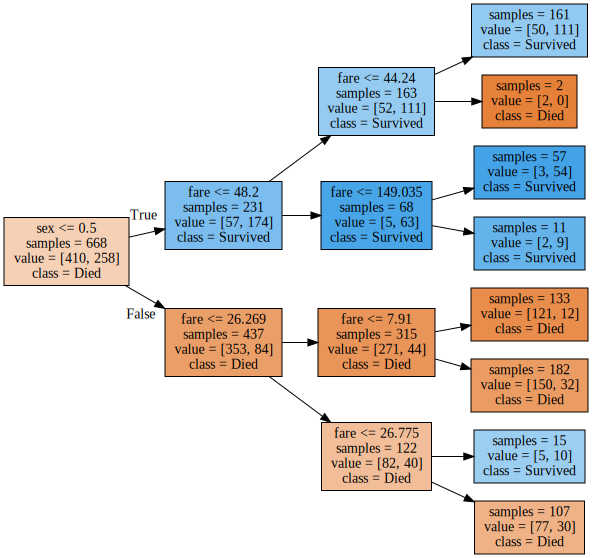

In [98]:
# visualize decision tree
dot_data = export_graphviz(model, out_file=None, feature_names=features, 
                           class_names=['Died', 'Survived'], 
                           filled=True, impurity=False, rotate=True)
graphviz.Source(dot_data)

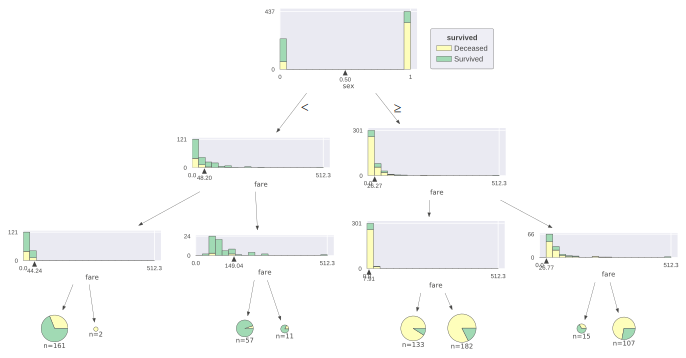

In [99]:
dtreeviz(model,
         train[features],
         train[target],
         target_name=target,
         feature_names=features, 
         class_names=['Deceased', 'Survived']) 

### Random Forest

In [102]:
# decision tree
model = RandomForestClassifier(max_depth=7, random_state=555)

for i in range(2, 8):
  for comb in combinations(features_all, i):
    features = list(comb)
    model.fit(train[features], train[target])
    print('Features:', features)

    # Train accuracy
    y_true = train[target]
    y_pred = model.predict(train[features])
    print('Train accuracy:', accuracy_score(y_true, y_pred))

    # Test accuracy
    y_true = test[target]
    y_pred = model.predict(test[features])
    print('Test accuracy:', accuracy_score(y_true, y_pred))
    
    print('Recall score:', recall_score(y_true, y_pred))
    print('Feature importance:', model.feature_importances_)
    print('Recall score:', recall_score(y_true, y_pred))
    print();

Features: ['pclass', 'sex']
Train accuracy: 0.7889221556886228
Test accuracy: 0.7802690582959642
Recall score: 0.7023809523809523
Feature importance: [0.24652807 0.75347193]
Recall score: 0.7023809523809523

Features: ['pclass', 'age']
Train accuracy: 0.7440119760479041
Test accuracy: 0.695067264573991
Recall score: 0.4166666666666667
Feature importance: [0.38048706 0.61951294]
Recall score: 0.4166666666666667

Features: ['pclass', 'sibsp']
Train accuracy: 0.6856287425149701
Test accuracy: 0.7040358744394619
Recall score: 0.5238095238095238
Feature importance: [0.6978519 0.3021481]
Recall score: 0.5238095238095238

Features: ['pclass', 'parch']
Train accuracy: 0.7065868263473054
Test accuracy: 0.726457399103139
Recall score: 0.5238095238095238
Feature importance: [0.747083 0.252917]
Recall score: 0.5238095238095238

Features: ['pclass', 'fare']
Train accuracy: 0.7739520958083832
Test accuracy: 0.7174887892376681
Recall score: 0.5
Feature importance: [0.1690655 0.8309345]
Recall score: 